In [1]:
import os
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tensorflow.python.keras.utils.np_utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.models import model_from_json
from PIL import Image, ImageChops, ImageEnhance
import PIL
from tqdm import tqdm
import tensorflow as tf

# Set seed for reproducibility
np.random.seed(2)

# Check TensorFlow version
print(tf.__version__)

2023-10-10 12:11:02.360487: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-10 12:11:02.360572: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-10 12:11:02.363204: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-10 12:11:02.620340: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-10 12:11:03.631672: W tensorflow/compiler/

2.14.0


In [3]:
DATA_DIR = 'CASIA2/'
print(os.listdir(DATA_DIR))

['CASIA 2 Groundtruth', 'Au', 'Tp']


In [4]:
# Check if the file is supported
SUPPORTED_FORMATS = ['.jpg', '.jpeg', '.png']

def is_supported_file(filename):
    ext = os.path.splitext(filename)[1].lower()
    return ext in SUPPORTED_FORMATS


# ELA function
def ELA(img_path, quality=75):
    TEMP = 'ela_temp.jpg'
    SCALE = 15  # Adjusted scale factor for better visualization
    
    original = Image.open(img_path)
    
    # Check if the image format is supported
    file_extension = os.path.splitext(img_path)[-1].lower()
    if file_extension not in SUPPORTED_FORMATS:
        raise ValueError(f"Unsupported file format: {file_extension}")
    
    try:
        # Always save as JPEG for the analysis, regardless of the original format
        original.save(TEMP, format='JPEG', quality=quality)
        temporary = Image.open(TEMP)
        diff = ImageChops.difference(original, temporary)
    except:
        original = original.convert('RGB')
        original.save(TEMP, format='JPEG', quality=quality)
        temporary = Image.open(TEMP)
        diff = ImageChops.difference(original, temporary)
    
    diff_np = np.asarray(diff)
    diff_np = (diff_np * SCALE).clip(0, 255).astype(np.uint8)
    diff = Image.fromarray(diff_np)
    
    # Enhance the contrast of the image for better visualization
    enhancer = ImageEnhance.Contrast(diff)
    diff = enhancer.enhance(2)  # Enhance by a factor of 2, adjust as needed
    return diff


# Paths
dataset_path = 'CASIA2/'
path_original = 'Au/'
path_tampered = 'Tp/'

total_original = os.listdir(dataset_path + path_original)
total_tampered = os.listdir(dataset_path + path_tampered)

pristine_images = [os.path.join(dataset_path, path_original, i) for i in total_original]
fake_images = [os.path.join(dataset_path, path_tampered, i) for i in total_tampered]

output_path = 'input/preprocessed-ela-images/'
fake_images_path = os.path.join(output_path, "resized_images", "fake_images")
pristine_images_path = os.path.join(output_path, "resized_images", "pristine_images")

if not os.path.exists(fake_images_path):
    os.makedirs(fake_images_path)
if not os.path.exists(pristine_images_path):
    os.makedirs(pristine_images_path)

height, width = 224, 224

# Process and save fake images
for fake_image in tqdm(total_tampered):
    if not is_supported_file(fake_image):
        print(f"Skipping unsupported file format: {fake_image}")
        continue
    
    try:
        img = Image.open(os.path.join(dataset_path, path_tampered, fake_image)).convert("RGB")
        img = img.resize((height, width), PIL.Image.LANCZOS)
        img.save(os.path.join(fake_images_path, fake_image))
    except Exception as e:
        print(f"Encountered Invalid File: {fake_image}. Error: {e}")

# Process and save pristine images
for pristine_image in tqdm(total_original):
    if not is_supported_file(pristine_image):
        print(f"Skipping unsupported file format: {pristine_image}")
        continue
    
    try:
        img = Image.open(os.path.join(dataset_path, path_original, pristine_image)).convert("RGB")
        img = img.resize((height, width), PIL.Image.LANCZOS)
        img.save(os.path.join(pristine_images_path, pristine_image))
    except Exception as e:
        print(f"Invalid File: {pristine_image}. Error: {e}")

print("Processing complete!")

  1%|▉                                                                                            | 52/5125 [00:00<00:09, 513.40it/s]

Skipping unsupported file format: Tp_S_NNN_S_N_sec20053_sec20053_01643.tif
Skipping unsupported file format: Tp_S_NRN_S_B_ani20050_ani20050_02093.tif
Skipping unsupported file format: Tp_S_CNN_S_N_txt00075_txt00075_00687.tif
Skipping unsupported file format: Tp_S_CND_S_N_art00094_art00094_10404.tif
Skipping unsupported file format: Tp_S_CNN_M_B_ani00009_ani00009_10214.tif
Skipping unsupported file format: Tp_S_NNN_S_B_nat20001_nat20001_01505.tif
Skipping unsupported file format: Tp_D_NRD_S_B_arc20100_arc20100_02185.tif
Skipping unsupported file format: Tp_D_NNN_S_N_arc00047_arc00086_00267.tif
Skipping unsupported file format: Tp_S_CNN_M_N_arc00052_arc00052_10264.tif
Skipping unsupported file format: Tp_D_CRN_M_N_arc00045_arc00071_10087.tif
Skipping unsupported file format: Tp_S_NRN_S_N_art00034_art00034_01220.tif
Skipping unsupported file format: Tp_S_NNN_S_N_arc00018_arc00018_00238.tif
Skipping unsupported file format: Tp_D_NNN_S_N_nat00092_nat00092_00684.tif
Skipping unsupported file

  4%|███▎                                                                                        | 184/5125 [00:00<00:07, 634.21it/s]

Skipping unsupported file format: Tp_D_NRN_S_N_art00050_cha00026_00522.tif
Skipping unsupported file format: Tp_S_NNN_S_N_ani00086_ani00086_00206.tif
Skipping unsupported file format: Tp_D_NRN_S_O_ani00084_ani00085_10058.tif
Skipping unsupported file format: Tp_S_NNN_S_N_ind00017_ind00017_00433.tif
Skipping unsupported file format: Tp_S_CRN_M_B_art00018_art00018_10034.tif
Skipping unsupported file format: Tp_S_NNN_S_B_nat00098_nat00098_00999.tif
Skipping unsupported file format: Tp_S_CNN_S_N_arc00011_arc00011_01110.tif
Skipping unsupported file format: Tp_D_NRD_L_N_art10104_txt00005_10231.tif
Skipping unsupported file format: Tp_S_NRN_S_N_nat20072_nat20072_01576.tif
Skipping unsupported file format: Tp_S_NRN_S_N_nat20018_nat20018_02218.tif
Skipping unsupported file format: Tp_D_NNN_S_B_sec00091_cha00085_00111.tif
Skipping unsupported file format: Tp_S_NNN_S_B_ani20003_ani20003_02402.tif
Skipping unsupported file format: Tp_D_NNN_S_N_art00058_ani00031_01402.tif
Skipping unsupported file

  6%|█████▌                                                                                      | 308/5125 [00:00<00:08, 557.95it/s]

Skipping unsupported file format: Tp_S_NNN_S_N_nat20010_nat20010_02210.tif
Skipping unsupported file format: Tp_S_NRN_S_N_art00093_art00093_10486.tif
Skipping unsupported file format: Tp_S_CRN_S_N_ind20050_ind20050_01791.tif
Skipping unsupported file format: Tp_D_CNN_S_N_art00096_cha00063_10305.tif
Skipping unsupported file format: Tp_D_NNN_M_N_txt00066_txt00065_10122.tif
Skipping unsupported file format: Tp_S_NND_S_N_ind20008_ind20008_02270.tif
Skipping unsupported file format: Tp_S_NNN_S_B_art00002_art00002_01428.tif
Skipping unsupported file format: Tp_S_NNN_S_N_cha20030_cha20030_02485.tif
Skipping unsupported file format: Tp_S_NRN_S_N_nat20023_nat20023_02223.tif
Skipping unsupported file format: Tp_S_NND_S_N_ani20025_ani20025_02068.tif
Skipping unsupported file format: Tp_S_CNN_M_N_pla00080_pla00080_10458.tif
Skipping unsupported file format: Tp_S_NRN_S_N_pla20046_pla20046_01946.tif
Skipping unsupported file format: Tp_S_NRN_S_N_ind20051_ind20051_01792.tif
Skipping unsupported file

  9%|███████▉                                                                                    | 442/5125 [00:00<00:08, 571.77it/s]

Skipping unsupported file format: Tp_D_CRN_M_B_ani00046_ani00001_10100.tif
Skipping unsupported file format: Tp_D_NRN_S_N_art00072_ani00100_01396.tif
Skipping unsupported file format: Tp_D_CRN_M_N_pla00026_pla00038_10147.tif
Skipping unsupported file format: Tp_D_NRN_S_N_cha00094_ani00068_00414.tif
Skipping unsupported file format: Tp_D_CNN_S_N_arc00020_arc00020_00240.tif
Skipping unsupported file format: Tp_S_NNN_S_N_arc20024_arc20024_02475.tif
Skipping unsupported file format: Tp_S_NNN_M_N_art00084_art00084_10521.tif
Skipping unsupported file format: Tp_S_NNN_M_N_ani00032_ani00032_00152.tif
Skipping unsupported file format: Tp_D_NRN_S_B_sec00012_sec00017_00032.tif
Skipping unsupported file format: Tp_S_NNN_S_N_ani00023_ani00023_00010.tif
Skipping unsupported file format: Tp_S_NRN_S_N_ani00068_ani00068_00188.tif
Skipping unsupported file format: Tp_S_NNN_S_N_ani20027_ani20027_02070.tif
Skipping unsupported file format: Tp_S_NNN_S_B_txt00028_txt00028_20117.tif
Skipping unsupported file

 11%|██████████                                                                                  | 560/5125 [00:00<00:08, 552.71it/s]

Skipping unsupported file format: Tp_S_CNN_S_N_ind00004_ind00004_00881.tif
Skipping unsupported file format: Tp_S_CND_S_B_sec00085_sec00085_00105.tif
Skipping unsupported file format: Tp_S_NND_S_N_arc00072_arc00072_01055.tif
Skipping unsupported file format: Tp_S_NNN_S_N_cha00095_cha00095_00874.tif
Skipping unsupported file format: Tp_S_NND_S_N_ani20051_ani20051_02094.tif
Skipping unsupported file format: Tp_D_NRN_M_N_ani00083_ani00083_10040.tif
Skipping unsupported file format: Tp_S_NRN_S_N_cha00080_cha00080_00400.tif
Skipping unsupported file format: Tp_S_NRN_S_N_art20005_art20005_02495.tif
Skipping unsupported file format: Tp_S_NNN_S_N_nat00044_nat00044_00658.tif
Skipping unsupported file format: Tp_D_NNN_S_N_sec00085_sec00085_00816.tif
Skipping unsupported file format: Tp_D_NRN_S_B_art00096_ani00070_01385.tif
Skipping unsupported file format: Tp_S_NRN_S_N_nat00063_nat00063_00974.tif
Skipping unsupported file format: Tp_S_NNN_S_N_art20080_art20080_01886.tif
Skipping unsupported file

 13%|████████████                                                                                | 672/5125 [00:01<00:08, 536.70it/s]

Skipping unsupported file format: Tp_S_NNN_S_N_arc20032_arc20032_01485.tif
Skipping unsupported file format: Tp_S_NND_S_N_cha20040_cha20040_02039.tif
Skipping unsupported file format: Tp_S_NNN_M_N_art00050_art00050_10535.tif
Skipping unsupported file format: Tp_D_NRN_S_N_ind00013_cha00023_00431.tif
Skipping unsupported file format: Tp_S_NND_S_N_pla20097_pla20097_02345.tif
Skipping unsupported file format: Tp_S_CNN_S_N_arc00074_arc00074_01053.tif
Skipping unsupported file format: Tp_D_NRN_M_N_cha00048_cha00063_10302.tif
Skipping unsupported file format: Tp_S_NNN_S_N_cha00019_cha00019_00339.tif
Skipping unsupported file format: Tp_S_CNN_M_N_ind00008_ind00008_10419.tif
Skipping unsupported file format: Tp_S_NNN_S_N_nat00050_nat00050_00660.tif
Skipping unsupported file format: Tp_S_CNN_S_N_art20031_art20031_01837.tif
Skipping unsupported file format: Tp_S_NRN_S_N_pla20094_pla20094_01994.tif
Skipping unsupported file format: Tp_S_NNN_S_N_pla00100_pla00100_00933.tif
Skipping unsupported file

 15%|██████████████                                                                              | 782/5125 [00:01<00:08, 508.00it/s]

Skipping unsupported file format: Tp_S_CRN_S_O_art00040_art00040_10463.tif
Skipping unsupported file format: Tp_S_NRN_S_B_nat20006_nat20006_02206.tif
Skipping unsupported file format: Tp_S_NRD_S_N_art00089_art00089_10339.tif
Skipping unsupported file format: Tp_S_NRN_S_N_art20086_art20086_02311.tif
Skipping unsupported file format: Tp_S_NNN_S_N_sec00008_sec00008_00028.tif
Skipping unsupported file format: Tp_S_NNN_S_N_ind00051_ind00051_00458.tif
Skipping unsupported file format: Tp_S_NNN_S_N_arc00016_arc00016_00236.tif
Skipping unsupported file format: Tp_D_NRN_M_N_txt00059_pla00050_10390.tif
Skipping unsupported file format: Tp_S_NNN_S_N_art00062_art00062_01027.tif
Skipping unsupported file format: Tp_D_CRD_M_N_arc00037_ani00005_10142.tif
Skipping unsupported file format: Tp_S_NRN_S_B_nat00098_nat00098_00995.tif
Skipping unsupported file format: Tp_S_NRN_S_N_sec20023_sec20023_01613.tif
Skipping unsupported file format: Tp_S_NND_S_N_art00078_art00078_01246.tif
Skipping unsupported file

 18%|████████████████▏                                                                           | 904/5125 [00:01<00:07, 547.47it/s]

Skipping unsupported file format: Tp_D_NRN_S_N_art00003_ani00037_00496.tif
Skipping unsupported file format: Tp_S_CNN_S_N_arc00049_arc00049_10247.tif
Skipping unsupported file format: Tp_S_NNN_S_N_sec00100_sec00100_00120.tif
Skipping unsupported file format: Tp_S_NNN_S_N_pla00084_pla00084_10454.tif
Skipping unsupported file format: Tp_S_NRD_S_N_arc00043_arc00043_01082.tif
Skipping unsupported file format: Tp_S_NNN_S_B_nat20092_nat20092_02458.tif
Skipping unsupported file format: Tp_S_CRN_S_N_pla20064_pla20064_01964.tif
Skipping unsupported file format: Tp_S_NNN_S_N_pla20064_pla20064_02369.tif
Skipping unsupported file format: Tp_S_NRN_S_N_ind00037_ind00037_01328.tif
Skipping unsupported file format: Tp_S_NNN_S_N_arc20053_arc20053_01693.tif
Skipping unsupported file format: Tp_D_NRN_S_N_cha00079_ani00068_00399.tif
Skipping unsupported file format: Tp_S_NND_S_N_pla00007_pla00007_01129.tif
Skipping unsupported file format: Tp_D_NNN_S_N_ind00093_cha00023_00487.tif
Skipping unsupported file

 20%|██████████████████                                                                         | 1017/5125 [00:01<00:07, 541.35it/s]

Skipping unsupported file format: Tp_D_NNN_M_N_arc00061_nat00074_10448.tif
Skipping unsupported file format: Tp_D_NRN_S_N_cha00024_ani00005_00344.tif
Skipping unsupported file format: Tp_S_NRN_S_O_arc00021_arc00021_01119.tif
Skipping unsupported file format: Tp_S_NNN_S_N_cha20036_cha20036_02487.tif
Skipping unsupported file format: Tp_S_NRN_S_B_pla20095_pla20095_01995.tif
Skipping unsupported file format: Tp_S_NRN_S_B_pla20090_pla20090_01990.tif
Skipping unsupported file format: Tp_S_CNN_M_N_art00024_art00024_10553.tif
Skipping unsupported file format: Tp_S_NRN_S_N_ind00006_ind00006_10417.tif
Skipping unsupported file format: Tp_S_NNN_S_N_art00020_art00020_01426.tif
Skipping unsupported file format: Tp_S_NNN_S_B_ind00011_ind00011_10413.tif
Skipping unsupported file format: Tp_S_NRN_S_N_arc00010_arc00010_01109.tif
Skipping unsupported file format: Tp_S_CRN_S_N_art20059_art20059_01865.tif
Skipping unsupported file format: Tp_S_NNN_S_N_pla00088_pla00088_01189.tif
Skipping unsupported file

 21%|███████████████████▎                                                                       | 1089/5125 [00:01<00:06, 584.52it/s]

Skipping unsupported file format: Tp_S_NRN_S_N_arc00090_arc00090_00781.tif
Skipping unsupported file format: Tp_S_NRN_S_N_ind20057_ind20057_02300.tif
Skipping unsupported file format: Tp_S_NNN_S_N_sec20012_sec20012_02121.tif
Skipping unsupported file format: Tp_D_NNN_S_N_ani00010_ani00017_10215.tif
Skipping unsupported file format: Tp_D_NNN_M_B_arc20101_arc20001_02184.tif
Skipping unsupported file format: Tp_D_CNN_S_N_sec00042_ani00070_10541.tif
Skipping unsupported file format: Tp_S_NND_S_N_ind20012_ind20012_01753.tif
Skipping unsupported file format: Tp_S_NNN_S_N_arc00061_arc00061_01065.tif
Skipping unsupported file format: Tp_S_NNN_S_N_cha00040_cha00040_00849.tif
Skipping unsupported file format: Tp_S_NRN_S_N_pla20017_pla20027_01927.tif
Skipping unsupported file format: Tp_S_CNN_M_N_art00031_art00031_10472.tif
Skipping unsupported file format: Tp_D_NRN_S_N_cha00016_ani00069_00336.tif
Skipping unsupported file format: Tp_S_NNN_S_N_ani00095_ani00095_00809.tif
Skipping unsupported file

 24%|█████████████████████▍                                                                     | 1206/5125 [00:02<00:06, 560.49it/s]

Skipping unsupported file format: Tp_S_CNN_S_N_ind00021_ind00021_01319.tif
Skipping unsupported file format: Tp_S_CNN_M_N_arc00043_arc00043_10242.tif
Skipping unsupported file format: Tp_S_NRN_S_N_ind20028_ind20028_01769.tif
Skipping unsupported file format: Tp_S_NRN_S_N_ind20032_ind20032_02286.tif
Skipping unsupported file format: Tp_D_NNN_S_B_nat00082_cha00096_00678.tif
Skipping unsupported file format: Tp_S_NRD_S_B_art00086_art00086_01011.tif
Skipping unsupported file format: Tp_S_NNN_S_B_nat20052_nat20052_02248.tif
Skipping unsupported file format: Tp_D_NNN_S_N_nat00042_nat00034_00961.tif
Skipping unsupported file format: Tp_S_NRN_S_N_cha20018_cha20018_02017.tif
Skipping unsupported file format: Tp_S_NNN_S_N_cha00072_cha00072_00860.tif
Skipping unsupported file format: Tp_S_NNN_S_B_sec20062_sec20062_01652.tif
Skipping unsupported file format: Tp_S_NNN_S_N_arc00016_arc00016_01114.tif
Skipping unsupported file format: Tp_S_NNN_S_N_art20017_art20017_01823.tif
Skipping unsupported file

 26%|████████████████████████                                                                   | 1355/5125 [00:02<00:05, 645.11it/s]

Skipping unsupported file format: Tp_S_NNN_S_N_ind20025_ind20025_01766.tif
Skipping unsupported file format: Tp_S_NNN_S_B_art00028_art00028_01215.tif
Skipping unsupported file format: Tp_D_CNN_S_N_txt00043_txt00051_10378.tif
Skipping unsupported file format: Tp_D_NNN_S_B_nat00036_cha00097_00650.tif
Skipping unsupported file format: Tp_D_CRD_S_N_sec00037_art00028_00058.tif
Skipping unsupported file format: Tp_S_NNN_S_N_ani20040_ani20040_02083.tif
Skipping unsupported file format: Tp_S_NRN_S_N_ani20061_ani20061_02103.tif
Skipping unsupported file format: Tp_S_NNN_S_B_cha20009_cha20009_02423.tif
Skipping unsupported file format: Tp_S_NNN_S_B_pla00054_pla00054_01163.tif
Skipping unsupported file format: Tp_S_NNN_S_N_ani00089_ani00089_00209.tif
Skipping unsupported file format: Tp_D_NNN_S_N_sec10113_sec10106_10330.tif
Skipping unsupported file format: Tp_S_NNN_S_N_txt00093_txt00093_00690.tif
Skipping unsupported file format: Tp_S_CNN_S_N_art00067_art00067_01239.tif
Skipping unsupported file

 29%|██████████████████████████▎                                                                | 1480/5125 [00:02<00:06, 538.24it/s]

Skipping unsupported file format: Tp_S_NRD_S_B_ind20017_ind20017_02274.tif
Skipping unsupported file format: Tp_S_NNN_S_N_ani00047_ani00047_00829.tif
Skipping unsupported file format: Tp_S_NNN_S_N_sec20100_sec20100_02139.tif
Skipping unsupported file format: Tp_S_NRN_M_N_cha00010_art00010_10170.tif
Skipping unsupported file format: Tp_S_NRN_M_N_arc00056_arc00056_10393.tif
Skipping unsupported file format: Tp_S_NRN_S_N_pla20083_pla20083_01983.tif
Skipping unsupported file format: Tp_S_NNN_S_N_arc20017_arc20017_01470.tif
Skipping unsupported file format: Tp_S_NNN_S_N_arc00001_arc00001_01103.tif
Skipping unsupported file format: Tp_S_NNN_S_N_arc20062_arc20062_01702.tif
Skipping unsupported file format: Tp_S_NNN_S_B_nat20002_nat20002_02202.tif
Skipping unsupported file format: Tp_S_NNN_M_N_ani00074_ani00074_10444.tif
Skipping unsupported file format: Tp_S_NNN_S_B_pla00003_pla00003_01125.tif
Skipping unsupported file format: Tp_S_NNN_S_N_cha00094_cha00094_00873.tif
Skipping unsupported file

 31%|████████████████████████████▍                                                              | 1605/5125 [00:02<00:06, 553.31it/s]

Skipping unsupported file format: Tp_D_NRN_S_N_ind00061_ani00098_00465.tif
Skipping unsupported file format: Tp_S_NRN_S_N_ani00045_ani00045_00831.tif
Skipping unsupported file format: Tp_S_NRN_S_N_sec20081_sec20081_01671.tif
Skipping unsupported file format: Tp_S_NRD_S_B_pla20089_nat20043_02353.tif
Skipping unsupported file format: Tp_S_NNN_S_N_ani20045_ani20045_02088.tif
Skipping unsupported file format: Tp_D_NNN_L_B_ani00070_nat00099_00190.tif
Skipping unsupported file format: Tp_S_CNN_S_N_ind20038_ind20038_02290.tif
Skipping unsupported file format: Tp_S_NNN_S_N_ind20043_ind20043_02291.tif
Skipping unsupported file format: Tp_S_CNN_S_N_arc00030_arc00030_00778.tif
Skipping unsupported file format: Tp_S_NRN_S_N_arc20034_arc20034_02473.tif
Skipping unsupported file format: Tp_D_NRD_M_O_sec20032_sec20032_01622.tif
Skipping unsupported file format: Tp_S_NNN_S_N_arc20003_arc20003_02466.tif
Skipping unsupported file format: Tp_S_NNN_S_B_arc00070_arc00070_01057.tif
Skipping unsupported file

 34%|██████████████████████████████▉                                                            | 1745/5125 [00:03<00:05, 611.29it/s]

Skipping unsupported file format: Tp_D_NNN_S_N_nat20015_nat20018_01519.tif
Skipping unsupported file format: Tp_S_NNN_S_N_art20036_art20036_01842.tif
Skipping unsupported file format: Tp_S_NNN_S_N_sec00069_sec00069_00787.tif
Skipping unsupported file format: Tp_D_NRN_S_N_arc00037_ani00070_00257.tif
Skipping unsupported file format: Tp_S_NRN_S_N_ind20006_ind20006_02266.tif
Skipping unsupported file format: Tp_S_NNN_S_N_nat00046_nat00046_00965.tif
Skipping unsupported file format: Tp_S_NRN_S_N_art20087_art20087_02310.tif
Skipping unsupported file format: Tp_S_NNN_S_B_arc00077_arc00077_00297.tif
Skipping unsupported file format: Tp_S_CNN_S_N_art00026_art00026_10548.tif
Skipping unsupported file format: Tp_S_NNN_S_N_arc00007_arc00007_01121.tif
Skipping unsupported file format: Tp_S_NNN_S_B_nat20049_nat20049_02245.tif
Skipping unsupported file format: Tp_S_NNN_S_B_nat00017_nat00017_00636.tif
Skipping unsupported file format: Tp_D_NRN_M_N_pla10115_pla10114_10395.tif
Skipping unsupported file

 35%|████████████████████████████████                                                           | 1807/5125 [00:03<00:05, 596.15it/s]

Skipping unsupported file format: Tp_D_NRD_S_N_cha00091_ani00058_00411.tif
Skipping unsupported file format: Tp_D_NNN_S_B_pla00090_cha00028_00348.tif
Skipping unsupported file format: Tp_S_NRN_S_B_arc00054_arc00054_01072.tif
Skipping unsupported file format: Tp_S_CNN_S_N_pla00026_pla00026_01143.tif
Skipping unsupported file format: Tp_S_NRD_S_N_sec00053_sec00053_00074.tif
Skipping unsupported file format: Tp_S_CNN_S_N_ani20032_ani20032_02075.tif
Skipping unsupported file format: Tp_S_NNN_S_B_arc00063_arc00063_00283.tif
Skipping unsupported file format: Tp_S_CNN_S_N_pla00010_pla00010_00549.tif
Skipping unsupported file format: Tp_S_NRN_S_N_nat00034_nat00034_00954.tif
Skipping unsupported file format: Tp_S_NNN_S_N_sec00020_sec00020_00761.tif
Skipping unsupported file format: Tp_S_NNN_S_N_pla00082_pla00082_00606.tif
Skipping unsupported file format: Tp_S_NRD_S_B_ani00059_ani00059_00179.tif
Skipping unsupported file format: Tp_S_NND_S_N_nat20093_nat20093_01597.tif
Skipping unsupported file

 38%|██████████████████████████████████▌                                                        | 1948/5125 [00:03<00:05, 602.38it/s]

Skipping unsupported file format: Tp_S_CND_M_B_sec00019_sec00019_00040.tif
Skipping unsupported file format: Tp_D_NNN_L_N_ani00010_nat00095_10218.tif
Skipping unsupported file format: Tp_S_NNN_S_B_nat20010_nat20010_01514.tif
Skipping unsupported file format: Tp_S_NNN_S_N_ani00007_ani00007_00127.tif
Skipping unsupported file format: Tp_S_CNN_S_N_sec00089_sec00089_10357.tif
Skipping unsupported file format: Tp_D_NRD_S_N_sec00078_sec00080_00099.tif
Skipping unsupported file format: Tp_S_NRD_S_B_cha20044_nat20042_02432.tif
Skipping unsupported file format: Tp_S_NNN_S_N_ind00016_ind00016_00888.tif
Skipping unsupported file format: Tp_D_CRN_S_N_art00005_art00005_00497.tif
Skipping unsupported file format: Tp_S_NNN_S_B_arc00004_arc00004_01104.tif
Skipping unsupported file format: Tp_D_NNN_S_B_nat20007_nat20011_02213.tif
Skipping unsupported file format: Tp_D_NRN_S_N_art00060_cha00051_01400.tif
Skipping unsupported file format: Tp_S_NNN_S_N_art00093_art00093_01251.tif
Skipping unsupported file

 41%|████████████████████████████████████▉                                                      | 2082/5125 [00:03<00:04, 623.01it/s]

Skipping unsupported file format: Tp_S_NNN_S_B_ind00036_ind00036_01327.tif
Skipping unsupported file format: Tp_S_NNN_S_N_ind00084_ind00084_00914.tif
Skipping unsupported file format: Tp_S_NNN_S_N_nat20050_nat20050_01554.tif
Skipping unsupported file format: Tp_S_NNN_S_B_nat00100_nat00100_00998.tif
Skipping unsupported file format: Tp_S_NRN_M_N_art00041_art00041_10544.tif
Skipping unsupported file format: Tp_S_NRN_S_N_art20009_art20009_01815.tif
Skipping unsupported file format: Tp_D_NRN_S_N_sec00087_ani00037_00720.tif
Skipping unsupported file format: Tp_S_NNN_S_N_nat00030_nat00030_00945.tif
Skipping unsupported file format: Tp_D_CRD_M_N_txt00068_txt00065_10135.tif
Skipping unsupported file format: Tp_S_CNN_S_N_sec00084_sec00084_00104.tif
Skipping unsupported file format: Tp_D_NRD_S_N_sec00025_sec00098_00046.tif
Skipping unsupported file format: Tp_D_NRN_S_N_ind00097_ind00098_01378.tif
Skipping unsupported file format: Tp_S_CNN_S_N_cha00057_cha00057_10112.tif
Skipping unsupported file

 43%|███████████████████████████████████████▏                                                   | 2207/5125 [00:03<00:04, 584.66it/s]

Skipping unsupported file format: Tp_D_NRN_S_B_ani00097_ani00097_10059.tif
Skipping unsupported file format: Tp_S_CND_S_B_nat00039_nat00039_00958.tif
Skipping unsupported file format: Tp_S_NNN_S_N_art00062_art00062_01398.tif
Skipping unsupported file format: Tp_S_CNN_S_N_arc20069_arc20069_01709.tif
Skipping unsupported file format: Tp_S_CNN_S_N_pla20069_pla20069_01969.tif
Skipping unsupported file format: Tp_S_NNN_S_N_arc20075_arc20075_01715.tif
Skipping unsupported file format: Tp_S_NNN_S_N_nat00035_nat00035_00951.tif
Skipping unsupported file format: Tp_S_NND_S_B_ind00071_ind00071_01358.tif
Skipping unsupported file format: Tp_S_NNN_S_N_arc00089_arc00089_01040.tif
Skipping unsupported file format: Tp_S_NNN_S_N_ind00050_ind00050_00901.tif
Skipping unsupported file format: Tp_S_NNN_S_N_ani00092_ani00092_00811.tif
Skipping unsupported file format: Tp_S_CNN_S_B_arc20018_arc20018_01471.tif
Skipping unsupported file format: Tp_D_NRN_M_B_sec00095_txt00068_10134.tif
Skipping unsupported file

 46%|█████████████████████████████████████████▊                                                 | 2352/5125 [00:04<00:04, 651.40it/s]

Skipping unsupported file format: Tp_D_CRN_S_N_sec00058_art00002_00079.tif
Skipping unsupported file format: Tp_S_NNN_S_N_arc20082_arc20082_01722.tif
Skipping unsupported file format: Tp_S_CNN_M_N_pla00035_pla00035_10149.tif
Skipping unsupported file format: Tp_S_CRN_S_N_sec00022_sec00022_00749.tif
Skipping unsupported file format: Tp_S_NNN_S_B_cha20015_cha20015_02014.tif
Skipping unsupported file format: Tp_S_NRD_S_N_ani00100_ani00100_00220.tif
Skipping unsupported file format: Tp_D_NNN_S_N_cha00045_cha00045_00365.tif
Skipping unsupported file format: Tp_S_NNN_S_N_sec00096_sec00096_00783.tif
Skipping unsupported file format: Tp_S_NNN_S_N_pla00021_pla00021_00559.tif
Skipping unsupported file format: Tp_S_CNN_M_N_txt00050_txt00050_10372.tif
Skipping unsupported file format: Tp_D_NRN_S_B_ind00046_cha00023_00454.tif
Skipping unsupported file format: Tp_S_NRD_S_B_ani20034_ani20034_02077.tif
Skipping unsupported file format: Tp_S_NNN_S_N_arc20002_arc20002_01455.tif
Skipping unsupported file

 49%|████████████████████████████████████████████▏                                              | 2492/5125 [00:04<00:04, 634.34it/s]

Skipping unsupported file format: Tp_S_CRN_S_N_sec00099_sec00099_00119.tif
Skipping unsupported file format: Tp_S_NNN_S_N_sec20036_sec20036_02450.tif
Skipping unsupported file format: Tp_S_NNN_S_N_nat00091_nat00091_00683.tif
Skipping unsupported file format: Tp_D_CRN_S_O_cha00030_ani00068_10042.tif
Skipping unsupported file format: Tp_S_CNN_M_N_art00047_art00047_10506.tif
Skipping unsupported file format: Tp_D_NND_M_N_arc00049_arc00092_00269.tif
Skipping unsupported file format: Tp_S_NNN_S_N_pla00003_pla00003_00543.tif
Skipping unsupported file format: Tp_S_NNN_S_N_art00044_art00044_10405.tif
Skipping unsupported file format: Tp_S_NNN_S_N_nat20003_nat20003_02203.tif
Skipping unsupported file format: Tp_S_NNN_S_N_sec00091_sec00091_00753.tif
Skipping unsupported file format: Tp_S_NNN_S_N_pla00067_pla00067_00598.tif
Skipping unsupported file format: Tp_S_NNN_S_B_nat00036_nat00036_00956.tif
Skipping unsupported file format: Tp_S_NNN_S_N_art20088_art20088_01894.tif
Skipping unsupported file

 51%|██████████████████████████████████████████████▋                                            | 2627/5125 [00:04<00:03, 631.38it/s]

Skipping unsupported file format: Tp_S_CNN_M_N_sec00043_sec00043_10492.tif
Skipping unsupported file format: Tp_S_NNN_S_N_pla20071_pla20071_02377.tif
Skipping unsupported file format: Tp_S_CNN_S_B_cha00047_cha00047_00367.tif
Skipping unsupported file format: Tp_S_NND_S_N_arc20094_arc20094_01734.tif
Skipping unsupported file format: Tp_S_CNN_M_N_sec00091_sec00091_10355.tif
Skipping unsupported file format: Tp_S_NRN_S_N_ind20009_ind20009_01750.tif
Skipping unsupported file format: Tp_S_CNN_M_N_cha00063_cha00063_10344.tif
Skipping unsupported file format: Tp_S_CNN_S_B_nat00016_nat00016_01000.tif
Skipping unsupported file format: Tp_S_NND_S_B_pla20084_pla20084_02357.tif
Skipping unsupported file format: Tp_D_NRD_L_N_ani10110_art10104_10229.tif
Skipping unsupported file format: Tp_S_NNN_S_B_arc20081_arc20081_02191.tif
Skipping unsupported file format: Tp_D_NNN_S_N_nat20019_nat20015_02219.tif
Skipping unsupported file format: Tp_S_NNN_S_N_arc20006_arc20006_01459.tif
Skipping unsupported file

 53%|███████████████████████████████████████████████▊                                           | 2691/5125 [00:04<00:04, 581.88it/s]

Skipping unsupported file format: Tp_S_NRN_S_N_art20074_art20074_02319.tif
Skipping unsupported file format: Tp_S_NNN_S_N_nat20017_nat20017_02217.tif
Skipping unsupported file format: Tp_S_NNN_S_N_ani20014_ani20014_02057.tif
Skipping unsupported file format: Tp_S_NNN_S_N_nat20021_nat20021_02221.tif
Skipping unsupported file format: Tp_S_NNN_M_N_txt00032_txt00032_10341.tif
Skipping unsupported file format: Tp_S_NRN_S_N_ani20037_ani20037_02080.tif
Skipping unsupported file format: Tp_S_NNN_S_N_nat20025_nat20025_01529.tif
Skipping unsupported file format: Tp_D_NRN_M_N_cha00050_cha00063_10301.tif
Skipping unsupported file format: Tp_S_NNN_S_N_pla00037_pla00037_01150.tif
Skipping unsupported file format: Tp_S_CNN_S_N_ind20053_ind20053_01794.tif
Skipping unsupported file format: Tp_S_CNN_M_N_ind00087_ind00087_10297.tif
Skipping unsupported file format: Tp_S_NNN_S_N_ind00054_ind00054_01343.tif
Skipping unsupported file format: Tp_D_CNN_S_B_ind00018_ind00089_00007.tif
Skipping unsupported file

 56%|██████████████████████████████████████████████████▌                                        | 2846/5125 [00:04<00:03, 671.57it/s]

Skipping unsupported file format: Tp_S_NNN_S_N_pla00011_pla00011_01133.tif
Skipping unsupported file format: Tp_S_NND_S_N_cha00049_cha00049_00852.tif
Skipping unsupported file format: Tp_S_NNN_S_N_pla00025_pla00025_01142.tif
Skipping unsupported file format: Tp_S_NRN_S_N_pla20030_pla20030_01930.tif
Skipping unsupported file format: Tp_S_NRD_S_B_arc00049_arc00049_01077.tif
Skipping unsupported file format: Tp_S_NNN_S_B_cha20027_cha20027_02426.tif
Skipping unsupported file format: Tp_S_NNN_S_N_sec00084_sec00084_00784.tif
Skipping unsupported file format: Tp_S_NRD_S_N_ind20021_ind20021_02278.tif
Skipping unsupported file format: Tp_D_NRD_S_N_ani00026_cha00047_00146.tif
Skipping unsupported file format: Tp_S_CNN_S_N_art20071_art20071_01877.tif
Skipping unsupported file format: Tp_D_CRN_M_N_nat00083_ani00001_10097.tif
Skipping unsupported file format: Tp_S_NNN_S_N_cha20010_cha20010_02424.tif
Skipping unsupported file format: Tp_S_NRD_S_B_ind00038_ind00038_01329.tif
Skipping unsupported file

 58%|████████████████████████████████████████████████████▉                                      | 2979/5125 [00:05<00:03, 590.08it/s]

Skipping unsupported file format: Tp_S_NNN_S_N_art00060_art00060_10475.tif
Skipping unsupported file format: Tp_S_NRN_S_B_pla20088_pla20088_02354.tif
Skipping unsupported file format: Tp_S_NND_S_N_ani20055_ani20055_02098.tif
Skipping unsupported file format: Tp_D_NNN_S_N_art00057_ind00018_01403.tif
Skipping unsupported file format: Tp_S_NNN_S_N_ind00040_ind00040_00897.tif
Skipping unsupported file format: Tp_S_NNN_S_B_pla00049_pla00049_01158.tif
Skipping unsupported file format: Tp_S_CNN_M_N_art00073_art00073_10477.tif
Skipping unsupported file format: Tp_S_NRN_M_N_cha00085_ani10104_10029.tif
Skipping unsupported file format: Tp_D_NNN_S_N_sec00086_cha00023_00705.tif
Skipping unsupported file format: Tp_S_NND_S_N_arc20019_arc20019_01472.tif
Skipping unsupported file format: Tp_S_CNN_M_N_art00064_art00064_10260.tif
Skipping unsupported file format: Tp_S_CRN_S_N_pla00005_pla00005_01127.tif
Skipping unsupported file format: Tp_S_NRN_S_B_ani00037_ani00037_00157.tif
Skipping unsupported file

 60%|██████████████████████████████████████████████████████▉                                    | 3097/5125 [00:05<00:03, 551.52it/s]

Skipping unsupported file format: Tp_S_NRN_S_N_txt00005_txt00005_01264.tif
Skipping unsupported file format: Tp_S_CNN_S_N_txt00050_txt00050_01277.tif
Skipping unsupported file format: Tp_S_NNN_S_N_ind00059_ind00059_01348.tif
Skipping unsupported file format: Tp_D_NND_S_N_nat00011_nat00007_00631.tif
Skipping unsupported file format: Tp_S_CNN_M_N_sec00083_sec00083_10354.tif
Skipping unsupported file format: Tp_S_NNN_S_N_sec20054_sec20054_02132.tif
Skipping unsupported file format: Tp_D_NRN_S_B_sec00081_cha00065_00101.tif
Skipping unsupported file format: Tp_S_NRN_S_N_arc20080_arc20080_01720.tif
Skipping unsupported file format: Tp_S_NND_S_B_ani00076_ani00076_00017.tif
Skipping unsupported file format: Tp_D_NNN_S_N_cha00099_cha00100_00419.tif
Skipping unsupported file format: Tp_S_NNN_S_N_pla00093_pla00093_00614.tif
Skipping unsupported file format: Tp_S_CND_S_N_pla00004_pla00004_01126.tif
Skipping unsupported file format: Tp_S_NNN_S_N_ani00071_ani00071_00827.tif
Skipping unsupported file

 63%|█████████████████████████████████████████████████████████▏                                 | 3219/5125 [00:05<00:03, 549.65it/s]

Skipping unsupported file format: Tp_S_NNN_S_N_arc00064_arc00064_01062.tif
Skipping unsupported file format: Tp_S_NNN_S_N_ind00060_ind00060_00907.tif
Skipping unsupported file format: Tp_S_NRD_S_B_arc20003_arc20003_01456.tif
Skipping unsupported file format: Tp_D_NRD_M_O_sec20087_sec20042_01677.tif
Skipping unsupported file format: Tp_S_CNN_M_N_txt10101_txt10101_10150.tif
Skipping unsupported file format: Tp_S_CRN_S_N_pla20058_pla20058_01958.tif
Skipping unsupported file format: Tp_D_NRD_S_B_art20007_arc20009_01813.tif
Skipping unsupported file format: Tp_S_NNN_S_N_sec20065_sec20065_01655.tif
Skipping unsupported file format: Tp_S_NND_S_N_ind00018_ind00018_00434.tif
Skipping unsupported file format: Tp_S_NNN_S_N_ind20060_ind20060_02303.tif
Skipping unsupported file format: Tp_S_NNN_S_N_pla00033_pla00033_00568.tif
Skipping unsupported file format: Tp_S_CNN_M_N_sec00086_sec00086_10360.tif
Skipping unsupported file format: Tp_S_NNN_S_N_ani00031_ani00031_00151.tif
Skipping unsupported file

 65%|███████████████████████████████████████████████████████████▌                               | 3351/5125 [00:05<00:03, 569.69it/s]

Skipping unsupported file format: Tp_S_NNN_S_N_ind00087_ind00087_01371.tif
Skipping unsupported file format: Tp_S_NNN_S_N_arc20012_arc20012_01465.tif
Skipping unsupported file format: Tp_S_NNN_S_N_arc20023_arc20023_02164.tif
Skipping unsupported file format: Tp_D_NRN_S_N_cha00028_ani00068_10043.tif
Skipping unsupported file format: Tp_S_NRD_S_B_ani00063_ani00063_00183.tif
Skipping unsupported file format: Tp_S_NNN_S_B_arc20088_arc20088_02414.tif
Skipping unsupported file format: Tp_S_NNN_S_N_sec00035_sec00035_00801.tif
Skipping unsupported file format: Tp_S_NNN_S_B_txt00079_txt00079_01288.tif
Skipping unsupported file format: Tp_S_CRD_S_N_ind20020_ind20020_02277.tif
Skipping unsupported file format: Tp_S_NNN_S_N_arc20089_arc20089_01729.tif
Skipping unsupported file format: Tp_S_NND_S_N_ani20029_ani20029_02072.tif
Skipping unsupported file format: Tp_S_CNN_S_N_art20053_art20053_01859.tif
Skipping unsupported file format: Tp_S_NNN_S_N_ind00099_ind00099_01377.tif
Skipping unsupported file

 67%|████████████████████████████████████████████████████████████▌                              | 3410/5125 [00:05<00:02, 573.73it/s]

Skipping unsupported file format: Tp_S_CNN_S_N_art00080_art00080_01247.tif
Skipping unsupported file format: Tp_S_NND_S_N_pla00048_pla00048_01157.tif
Skipping unsupported file format: Tp_S_NNN_S_N_pla00072_pla00072_00600.tif
Skipping unsupported file format: Tp_S_NNN_S_N_pla20005_pla20005_02397.tif
Skipping unsupported file format: Tp_S_CNN_S_N_pla00046_pla00046_00581.tif
Skipping unsupported file format: Tp_S_NNN_S_N_ind20005_ind20005_01746.tif
Skipping unsupported file format: Tp_S_NND_S_N_nat20097_nat20097_02260.tif
Skipping unsupported file format: Tp_S_NNN_S_N_art20077_art20077_01883.tif
Skipping unsupported file format: Tp_S_NND_S_N_arc20020_arc20020_02470.tif
Skipping unsupported file format: Tp_S_NNN_S_N_sec20035_sec20035_01625.tif
Skipping unsupported file format: Tp_S_NRD_S_N_cha00066_cha00066_00857.tif
Skipping unsupported file format: Tp_S_NRN_S_N_nat20041_nat20041_01545.tif
Skipping unsupported file format: Tp_S_NNN_S_N_cha00082_cha00082_00867.tif
Skipping unsupported file

 69%|███████████████████████████████████████████████████████████████                            | 3551/5125 [00:06<00:02, 633.64it/s]

Skipping unsupported file format: Tp_D_NNN_S_N_ind00019_ind00020_00435.tif
Skipping unsupported file format: Tp_S_NNN_S_N_arc20030_arc20030_01483.tif
Skipping unsupported file format: Tp_S_NNN_S_B_pla20099_pla20099_02343.tif
Skipping unsupported file format: Tp_D_NRD_L_N_art10104_ani10110_10230.tif
Skipping unsupported file format: Tp_S_NNN_S_B_arc00099_arc00099_01031.tif
Skipping unsupported file format: Tp_S_NRN_S_N_txt00062_txt00062_01284.tif
Skipping unsupported file format: Tp_S_NRD_S_N_cha00091_cha00091_00872.tif
Skipping unsupported file format: Tp_S_NNN_S_N_pla20044_pla20044_01944.tif
Skipping unsupported file format: Tp_D_CRN_M_N_ani00097_ani10101_10090.tif
Skipping unsupported file format: Tp_S_NRN_S_B_pla00082_pla00082_01184.tif
Skipping unsupported file format: Tp_S_NNN_S_N_ind00064_ind00064_00910.tif
Skipping unsupported file format: Tp_S_NRN_S_N_pla20080_pla20080_01980.tif
Skipping unsupported file format: Tp_S_CNN_S_N_art20090_art20090_02307.tif
Skipping unsupported file

 72%|█████████████████████████████████████████████████████████████████▎                         | 3679/5125 [00:06<00:02, 616.64it/s]

Skipping unsupported file format: Tp_S_CNN_M_N_sec00042_sec00042_10493.tif
Skipping unsupported file format: Tp_S_CnN_S_N_txt00071_txt00071_01297.tif
Skipping unsupported file format: Tp_S_CNN_M_N_ind00009_ind00009_10415.tif
Skipping unsupported file format: Tp_S_NRN_S_B_art00072_art00072_01015.tif
Skipping unsupported file format: Tp_S_NNN_S_N_arc20051_arc20051_01691.tif
Skipping unsupported file format: Tp_D_CRN_M_N_arc00071_arc00045_10085.tif
Skipping unsupported file format: Tp_S_NNN_S_B_ind00077_ind00077_01363.tif
Skipping unsupported file format: Tp_D_CRD_S_N_cha00059_cha00057_00379.tif
Skipping unsupported file format: Tp_S_NRN_S_N_pla00066_pla00066_01173.tif
Skipping unsupported file format: Tp_S_CRN_M_N_arc00072_arc00072_10265.tif
Skipping unsupported file format: Tp_S_CNN_S_B_pla00050_pla00050_01159.tif
Skipping unsupported file format: Tp_S_NNN_S_N_nat20004_nat20004_01508.tif
Skipping unsupported file format: Tp_D_NNN_S_N_ind20047_ind20049_01788.tif
Skipping unsupported file

 74%|███████████████████████████████████████████████████████████████████▌                       | 3802/5125 [00:06<00:02, 593.85it/s]

Skipping unsupported file format: Tp_S_CRN_S_N_arc20043_arc20043_02179.tif
Skipping unsupported file format: Tp_S_CNN_S_N_pla20054_pla20054_01954.tif
Skipping unsupported file format: Tp_S_CND_S_N_ani00009_ani00009_00129.tif
Skipping unsupported file format: Tp_S_CNN_S_N_txt00075_txt00075_01300.tif
Skipping unsupported file format: Tp_S_NNN_S_N_sec20074_sec20074_01664.tif
Skipping unsupported file format: Tp_S_NRN_S_N_nat20034_nat20034_01538.tif
Skipping unsupported file format: Tp_S_CNN_M_N_art00071_art00071_10480.tif
Skipping unsupported file format: Tp_D_CNN_S_B_cha00025_cha00025_00345.tif
Skipping unsupported file format: Tp_S_NNN_S_N_ind20059_ind20059_02302.tif
Skipping unsupported file format: Tp_S_NND_S_B_sec00081_sec00081_00035.tif
Skipping unsupported file format: Tp_S_NNN_S_N_sec20027_sec20027_02125.tif
Skipping unsupported file format: Tp_D_NRN_S_N_pla00091_ani00031_00935.tif
Skipping unsupported file format: Tp_S_NNN_S_B_art00057_art00057_01232.tif
Skipping unsupported file

 77%|█████████████████████████████████████████████████████████████████████▉                     | 3936/5125 [00:06<00:01, 618.75it/s]

Skipping unsupported file format: Tp_S_NNN_S_B_ind20027_ind20027_02282.tif
Skipping unsupported file format: Tp_D_CRN_S_N_ind00089_ind00088_00484.tif
Skipping unsupported file format: Tp_S_NRN_S_B_sec20014_sec20014_01449.tif
Skipping unsupported file format: Tp_S_NNN_S_N_cha00066_cha00066_10320.tif
Skipping unsupported file format: Tp_S_NND_S_N_ind00035_ind00035_01326.tif
Skipping unsupported file format: Tp_S_NRN_S_N_sec00041_sec00041_10501.tif
Skipping unsupported file format: Tp_D_NNN_M_N_arc00054_arc00005_10006.tif
Skipping unsupported file format: Tp_S_NNN_S_N_nat00056_nat00056_00664.tif
Skipping unsupported file format: Tp_S_NRN_S_N_ind00055_ind00055_00905.tif
Skipping unsupported file format: Tp_S_CNN_S_N_sec20023_sec20023_02123.tif
Skipping unsupported file format: Tp_S_NNN_S_N_sec00036_sec00036_00737.tif
Skipping unsupported file format: Tp_D_NRN_M_N_txt10112_nat10103_10111.tif
Skipping unsupported file format: Tp_D_NRN_S_B_art00044_ind00098_00490.tif
Skipping unsupported file

 79%|████████████████████████████████████████████████████████████████████████                   | 4061/5125 [00:06<00:01, 587.35it/s]

Skipping unsupported file format: Tp_S_NND_S_N_sec20068_sec20068_01658.tif
Skipping unsupported file format: Tp_S_NNN_S_N_pla20057_pla20057_02374.tif
Skipping unsupported file format: Tp_D_NRN_S_N_sec00095_ani00098_00712.tif
Skipping unsupported file format: Tp_S_NNN_S_N_art00050_art00050_01024.tif
Skipping unsupported file format: Tp_S_CNN_M_N_arc00063_arc00063_10256.tif
Skipping unsupported file format: Tp_S_NNN_S_N_art20054_art20054_01860.tif
Skipping unsupported file format: Tp_D_NRN_S_B_nat00083_sec00063_00997.tif
Skipping unsupported file format: Tp_S_NRD_S_B_ani00061_ani00061_00181.tif
Skipping unsupported file format: Tp_S_NNN_S_N_pla00040_pla00040_00575.tif
Skipping unsupported file format: Tp_S_NNN_S_N_sec00028_sec00028_00767.tif
Skipping unsupported file format: Tp_S_NNN_S_N_nat20064_nat20064_01568.tif
Skipping unsupported file format: Tp_S_NNN_S_N_art20047_art20047_02333.tif
Skipping unsupported file format: Tp_S_NNN_S_N_ind20042_ind20042_01783.tif
Skipping unsupported file

 82%|██████████████████████████████████████████████████████████████████████████▍                | 4192/5125 [00:07<00:01, 596.00it/s]

Skipping unsupported file format: Tp_S_NNN_S_B_art00060_art00060_01235.tif
Skipping unsupported file format: Tp_S_NNN_S_N_ind00005_ind00005_00882.tif
Skipping unsupported file format: Tp_S_NRN_S_N_nat20057_nat20057_01561.tif
Skipping unsupported file format: Tp_D_CRN_S_N_pla00037_pla00038_10064.tif
Skipping unsupported file format: Tp_S_NRN_S_N_art20034_art20034_02335.tif
Skipping unsupported file format: Tp_D_NND_M_B_sec00077_txt00059_10387.tif
Skipping unsupported file format: Tp_S_NRD_S_N_nat00028_nat00028_00644.tif
Skipping unsupported file format: Tp_S_NRN_S_N_cha00064_cha00064_00383.tif
Skipping unsupported file format: Tp_S_NNN_S_N_ind00075_ind00075_00911.tif
Skipping unsupported file format: Tp_S_NNN_M_N_art00068_art00068_10460.tif
Skipping unsupported file format: Tp_S_CNN_S_N_pla20049_pla20049_01949.tif
Skipping unsupported file format: Tp_S_NND_S_N_ani00048_ani00048_00168.tif
Skipping unsupported file format: Tp_S_NNN_S_N_arc00062_arc00062_01064.tif
Skipping unsupported file

 84%|████████████████████████████████████████████████████████████████████████████▋              | 4316/5125 [00:07<00:01, 575.27it/s]

Skipping unsupported file format: Tp_S_CNN_S_N_art00085_art00085_10283.tif
Skipping unsupported file format: Tp_S_NRD_S_B_ani00046_ani00046_01259.tif
Skipping unsupported file format: Tp_S_NNN_S_N_pla20077_pla20077_01977.tif
Skipping unsupported file format: Tp_S_CNN_S_N_pla20069_pla20069_02366.tif
Skipping unsupported file format: Tp_S_NRD_S_N_pla20081_pla20081_01981.tif
Skipping unsupported file format: Tp_S_NND_S_N_cha20003_cha20003_02418.tif
Skipping unsupported file format: Tp_D_CRD_S_B_ani00071_ani00064_00191.tif
Skipping unsupported file format: Tp_S_CRN_S_N_nat00098_nat00098_10063.tif
Skipping unsupported file format: Tp_S_NNN_S_N_ani20020_ani20020_02063.tif
Skipping unsupported file format: Tp_S_NRN_S_B_arc20011_arc20011_01464.tif
Skipping unsupported file format: _list.txt
Skipping unsupported file format: Tp_S_NNN_S_N_ind20061_ind20061_01802.tif
Skipping unsupported file format: Tp_D_NRN_S_B_art00063_ani00058_00528.tif
Skipping unsupported file format: Tp_S_NNN_S_N_arc20019_

 87%|███████████████████████████████████████████████████████████████████████████████            | 4452/5125 [00:07<00:01, 622.93it/s]

Skipping unsupported file format: Tp_S_NNN_S_N_sec20040_sec20040_01630.tif
Skipping unsupported file format: Tp_S_NRN_S_N_arc00091_arc00091_01039.tif
Skipping unsupported file format: Tp_D_NRN_M_O_arc00023_arc00008_10010.tif
Skipping unsupported file format: Tp_D_NRN_S_N_sec00041_ani00076_10500.tif
Skipping unsupported file format: Tp_D_NRD_S_N_arc00025_cha00001_00245.tif
Skipping unsupported file format: Tp_S_NNN_S_B_art00046_art00046_00926.tif
Skipping unsupported file format: Tp_S_NRD_S_N_ind00011_ind00011_01309.tif
Skipping unsupported file format: Tp_D_NRN_S_N_arc00019_arc00019_00239.tif
Skipping unsupported file format: Tp_S_NRN_S_N_cha20022_cha20022_02021.tif
Skipping unsupported file format: Tp_D_NRN_L_O_sec00043_cha00097_00064.tif
Skipping unsupported file format: Tp_S_CRD_S_N_pla20002_pla20002_02398.tif
Skipping unsupported file format: Tp_D_NRN_S_B_sec00002_ani00017_01432.tif
Skipping unsupported file format: Tp_D_NRN_M_O_ani10105_ani10104_10022.tif
Skipping unsupported file

 89%|█████████████████████████████████████████████████████████████████████████████████▍         | 4583/5125 [00:07<00:00, 611.80it/s]

Skipping unsupported file format: Tp_S_NND_S_N_ani20022_ani20022_02440.tif
Skipping unsupported file format: Tp_S_NNN_S_N_art20063_art20063_01869.tif
Skipping unsupported file format: Tp_S_NNN_S_N_cha20019_cha20019_02018.tif
Skipping unsupported file format: Tp_S_NRN_S_N_arc00062_arc00062_00282.tif
Skipping unsupported file format: Tp_S_NNN_S_N_ind00017_ind00017_01315.tif
Skipping unsupported file format: Tp_D_NNN_L_O_ani00001_nat00037_00121.tif
Skipping unsupported file format: Tp_S_NNN_S_N_sec00072_sec00072_10385.tif
Skipping unsupported file format: Tp_D_NRN_S_N_art00033_ani00013_00511.tif
Skipping unsupported file format: Tp_D_NRN_S_N_nat00013_ani00005_00633.tif
Skipping unsupported file format: Tp_S_CND_S_N_ind20036_ind20036_01777.tif
Skipping unsupported file format: Tp_S_NRN_S_N_pla20025_pla20025_01925.tif
Skipping unsupported file format: Tp_S_NRD_S_O_nat00039_nat00039_00964.tif
Skipping unsupported file format: Tp_S_CRD_S_N_cha00060_cha00060_00380.tif
Skipping unsupported file

 91%|██████████████████████████████████████████████████████████████████████████████████▍        | 4645/5125 [00:07<00:00, 553.90it/s]

Skipping unsupported file format: Tp_S_NND_S_N_pla20021_pla20021_01921.tif
Skipping unsupported file format: Tp_S_CRN_M_N_art00058_art00058_10530.tif
Skipping unsupported file format: Tp_S_NNN_S_N_ind20038_ind20038_01779.tif
Skipping unsupported file format: Tp_S_NNN_S_B_nat20015_nat20015_02215.tif
Skipping unsupported file format: Tp_S_NRN_S_N_pla20047_pla20047_01947.tif
Skipping unsupported file format: Tp_S_NRN_S_B_arc00029_arc00029_01093.tif
Skipping unsupported file format: Tp_S_NNN_S_N_arc20024_arc20024_01477.tif
Skipping unsupported file format: Tp_S_NRN_S_B_art00061_sec00099_00527.tif
Skipping unsupported file format: Tp_D_NNN_S_O_arc00012_ani00001_00232.tif
Skipping unsupported file format: Tp_D_CNN_S_N_art00001_ani00074_10442.tif
Skipping unsupported file format: Tp_D_CRN_M_O_pla10102_ani10104_10028.tif
Skipping unsupported file format: Tp_S_NNN_S_N_arc20006_arc20006_02467.tif
Skipping unsupported file format: Tp_S_NRN_S_N_pla20041_pla20041_01941.tif
Skipping unsupported file

 93%|████████████████████████████████████████████████████████████████████████████████████▌      | 4763/5125 [00:08<00:00, 566.25it/s]

Skipping unsupported file format: Tp_S_NNN_S_B_nat00061_nat00061_00972.tif
Skipping unsupported file format: Tp_D_NRN_M_N_nat00083_ani00037_10055.tif
Skipping unsupported file format: Tp_S_NNN_S_N_art00056_art00056_01404.tif
Skipping unsupported file format: Tp_S_NRD_S_N_sec20063_sec20063_01653.tif
Skipping unsupported file format: Tp_S_CRN_S_N_sec20051_sec20051_01641.tif
Skipping unsupported file format: Tp_S_NNN_S_N_art20089_art20089_01895.tif
Skipping unsupported file format: Tp_S_NNN_S_N_arc20002_arc20002_02465.tif
Skipping unsupported file format: Tp_D_NNN_L_O_sec00062_nat00083_00083.tif
Skipping unsupported file format: Tp_D_CND_M_N_art00076_art00077_10289.tif
Skipping unsupported file format: Tp_D_NRD_S_N_sec00018_cha00063_00039.tif
Skipping unsupported file format: Tp_S_CNN_M_N_cha00082_cha00082_10197.tif
Skipping unsupported file format: Tp_D_NNN_S_N_art00033_cha00063_01421.tif
Skipping unsupported file format: Tp_S_CRD_S_N_ind00052_ind00052_10402.tif
Skipping unsupported file

 96%|██████████████████████████████████████████████████████████████████████████████████████▉    | 4895/5125 [00:08<00:00, 601.03it/s]

Skipping unsupported file format: Tp_D_NRN_S_N_cha00062_cha00062_00381.tif
Skipping unsupported file format: Tp_S_NNN_S_N_nat00047_nat00047_00966.tif
Skipping unsupported file format: Tp_S_NRN_S_N_nat20078_nat20078_01582.tif
Skipping unsupported file format: Tp_S_NNN_S_N_cha20029_cha20029_02428.tif
Skipping unsupported file format: Tp_S_NRN_S_N_pla20099_pla20099_01999.tif
Skipping unsupported file format: Tp_S_NRN_S_N_ani20039_ani20039_02082.tif
Skipping unsupported file format: Tp_S_NNN_S_N_nat20062_nat20062_01566.tif
Skipping unsupported file format: Tp_S_NNN_S_N_arc20063_arc20063_01703.tif
Skipping unsupported file format: Tp_S_NNN_S_B_arc20048_arc20048_02182.tif
Skipping unsupported file format: Tp_D_NND_L_B_arc00033_nat00095_00253.tif
Skipping unsupported file format: Tp_S_NRD_S_N_cha00084_cha00084_00879.tif
Skipping unsupported file format: Tp_S_NNN_S_N_pla20073_pla20073_01973.tif
Skipping unsupported file format: Tp_S_NNN_S_N_art20023_art20023_01829.tif
Skipping unsupported file

 98%|█████████████████████████████████████████████████████████████████████████████████████████▎ | 5029/5125 [00:08<00:00, 589.92it/s]

Skipping unsupported file format: Tp_D_NNN_M_O_arc00041_nat00097_00261.tif
Skipping unsupported file format: Tp_S_NNN_S_N_ani00081_ani00081_00819.tif
Skipping unsupported file format: Tp_S_CNN_S_N_art20086_art20086_01892.tif
Skipping unsupported file format: Tp_S_NRN_S_N_cha00039_cha00039_00359.tif
Skipping unsupported file format: Tp_S_NND_S_N_ani00032_ani00032_00016.tif
Skipping unsupported file format: Tp_S_NNN_S_N_nat00058_nat00058_00665.tif
Skipping unsupported file format: Tp_S_NRN_S_N_art20068_art20068_01874.tif
Skipping unsupported file format: Tp_S_CNN_M_O_arc00030_arc00030_10067.tif
Skipping unsupported file format: Tp_S_NND_S_N_ind00010_ind00010_00885.tif
Skipping unsupported file format: Tp_D_NRN_S_N_art20035_art20036_02492.tif
Skipping unsupported file format: Tp_S_NRD_S_N_pla00040_pla00040_01152.tif
Skipping unsupported file format: Tp_D_NNN_M_N_art00088_txt00098_10326.tif
Skipping unsupported file format: Tp_S_NNN_S_B_art00082_art00082_01248.tif
Skipping unsupported file

100%|███████████████████████████████████████████████████████████████████████████████████████████| 5125/5125 [00:08<00:00, 587.48it/s]


Skipping unsupported file format: Tp_S_NND_S_B_pla20081_pla20081_02359.tif
Skipping unsupported file format: Tp_S_NNN_S_N_art00078_art00078_00532.tif
Skipping unsupported file format: Tp_D_NNN_S_B_nat00036_nat00034_20124.tif
Skipping unsupported file format: Tp_S_NNN_S_B_nat20027_nat20027_02227.tif
Skipping unsupported file format: Tp_S_NRN_S_N_ani20065_ani20065_02107.tif
Skipping unsupported file format: Tp_S_CRN_S_N_sec00033_sec00033_00054.tif
Skipping unsupported file format: Tp_S_CRN_S_N_art20002_art20002_02497.tif
Skipping unsupported file format: Tp_S_CRN_M_N_cha00017_cha00017_10312.tif
Skipping unsupported file format: Tp_S_CNN_S_N_nat00009_nat00009_00629.tif
Skipping unsupported file format: Tp_D_NRN_S_B_arc00089_ani00061_00309.tif
Skipping unsupported file format: Tp_S_NRN_S_N_sec20019_sec20019_01609.tif
Skipping unsupported file format: Tp_D_NRN_S_B_sec00063_cha00001_00084.tif
Skipping unsupported file format: Tp_S_NNN_S_B_sec20069_sec20069_01659.tif
Skipping unsupported file

  0%|▍                                                                                            | 31/7492 [00:00<00:24, 305.75it/s]

Skipping unsupported file format: Au_nat_10152.bmp


  8%|███████                                                                                     | 575/7492 [00:01<00:22, 310.66it/s]

Skipping unsupported file format: Au_nat_10150.bmp
Skipping unsupported file format: Au_arc_10126.bmp


 11%|██████████▍                                                                                 | 849/7492 [00:02<00:20, 321.51it/s]

Skipping unsupported file format: Au_nat_10168.bmp
Skipping unsupported file format: Au_nat_10136.bmp


 14%|█████████████                                                                              | 1078/7492 [00:03<00:20, 319.49it/s]

Skipping unsupported file format: Au_arc_10128.bmp


 17%|███████████████▊                                                                           | 1306/7492 [00:04<00:19, 314.37it/s]

Skipping unsupported file format: Au_nat_10131.bmp
Skipping unsupported file format: Au_nat_10146.bmp


 19%|█████████████████                                                                          | 1402/7492 [00:04<00:19, 310.14it/s]

Skipping unsupported file format: Au_nat_10156.bmp
Skipping unsupported file format: Au_pla_10128.bmp


 22%|████████████████████▏                                                                      | 1657/7492 [00:05<00:19, 294.27it/s]

Skipping unsupported file format: Au_nat_10134.bmp


 24%|█████████████████████▊                                                                     | 1791/7492 [00:05<00:17, 324.08it/s]

Skipping unsupported file format: Au_sec_10116.bmp
Skipping unsupported file format: Au_nat_10159.bmp


 26%|███████████████████████▊                                                                   | 1957/7492 [00:06<00:17, 316.15it/s]

Skipping unsupported file format: Au_nat_10149.bmp


 27%|████████████████████████▉                                                                  | 2055/7492 [00:06<00:17, 312.20it/s]

Skipping unsupported file format: Au_nat_10133.bmp


 33%|█████████████████████████████▌                                                             | 2436/7492 [00:07<00:16, 314.50it/s]

Skipping unsupported file format: Au_nat_10148.bmp


 33%|██████████████████████████████▍                                                            | 2501/7492 [00:08<00:16, 311.26it/s]

Skipping unsupported file format: Au_nat_10161.bmp


 38%|██████████████████████████████████▉                                                        | 2873/7492 [00:09<00:14, 326.07it/s]

Skipping unsupported file format: Au_nat_10135.bmp


 40%|████████████████████████████████████▌                                                      | 3007/7492 [00:09<00:13, 330.22it/s]

Skipping unsupported file format: Au_arc_10127.bmp
Skipping unsupported file format: Au_nat_10138.bmp
Skipping unsupported file format: Au_nat_10163.bmp


 41%|█████████████████████████████████████▊                                                     | 3108/7492 [00:09<00:13, 326.88it/s]

Skipping unsupported file format: Au_nat_10151.bmp
Skipping unsupported file format: Au_arc_10129.bmp


 43%|███████████████████████████████████████▍                                                   | 3245/7492 [00:10<00:12, 333.36it/s]

Skipping unsupported file format: Au_nat_10142.bmp
Skipping unsupported file format: Au_arc_10123.bmp


 46%|█████████████████████████████████████████▉                                                 | 3453/7492 [00:11<00:12, 326.67it/s]

Skipping unsupported file format: Au_nat_10147.bmp


 49%|████████████████████████████████████████████▎                                              | 3650/7492 [00:11<00:12, 297.11it/s]

Skipping unsupported file format: Au_nat_10144.bmp
Skipping unsupported file format: Au_nat_10158.bmp


 50%|█████████████████████████████████████████████▍                                             | 3745/7492 [00:11<00:12, 298.86it/s]

Skipping unsupported file format: Au_arc_10130.bmp


 51%|██████████████████████████████████████████████▎                                            | 3812/7492 [00:12<00:11, 310.36it/s]

Skipping unsupported file format: Au_nat_10165.bmp


 57%|███████████████████████████████████████████████████▉                                       | 4278/7492 [00:13<00:10, 300.81it/s]

Skipping unsupported file format: Au_nat_10154.bmp
Skipping unsupported file format: Au_arc_10121.bmp
Skipping unsupported file format: Au_nat_10164.bmp


 59%|██████████████████████████████████████████████████████                                     | 4447/7492 [00:14<00:09, 330.88it/s]

Skipping unsupported file format: Au_nat_10132.bmp


 61%|███████████████████████████████████████████████████████▏                                   | 4548/7492 [00:14<00:09, 317.50it/s]

Skipping unsupported file format: Au_nat_10153.bmp


 65%|██████████████████████████████████████████████████████████▊                                | 4844/7492 [00:15<00:08, 296.89it/s]

Skipping unsupported file format: Au_nat_10141.bmp


 67%|████████████████████████████████████████████████████████████▊                              | 5011/7492 [00:16<00:08, 306.14it/s]

Skipping unsupported file format: Au_arc_10122.bmp


 68%|█████████████████████████████████████████████████████████████▋                             | 5074/7492 [00:16<00:07, 306.56it/s]

Skipping unsupported file format: Au_nat_10157.bmp


 70%|███████████████████████████████████████████████████████████████▉                           | 5268/7492 [00:16<00:07, 303.54it/s]

Skipping unsupported file format: Au_nat_10139.bmp


 72%|█████████████████████████████████████████████████████████████████▌                         | 5397/7492 [00:17<00:07, 293.94it/s]

Skipping unsupported file format: Au_arc_10125.bmp


 75%|████████████████████████████████████████████████████████████████████                       | 5600/7492 [00:17<00:05, 316.84it/s]

Skipping unsupported file format: Au_pla_10126.bmp


 77%|█████████████████████████████████████████████████████████████████████▉                     | 5759/7492 [00:18<00:05, 302.87it/s]

Skipping unsupported file format: Au_nat_10137.bmp


 78%|███████████████████████████████████████████████████████████████████████▏                   | 5857/7492 [00:18<00:05, 294.44it/s]

Skipping unsupported file format: Au_nat_10145.bmp


 79%|███████████████████████████████████████████████████████████████████████▉                   | 5920/7492 [00:19<00:05, 299.88it/s]

Skipping unsupported file format: Thumbs.db
Skipping unsupported file format: Au_nat_10140.bmp


 83%|███████████████████████████████████████████████████████████████████████████▉               | 6249/7492 [00:20<00:03, 331.78it/s]

Skipping unsupported file format: Au_arc_10124.bmp
Skipping unsupported file format: Au_nat_10162.bmp
Skipping unsupported file format: Au_nat_10155.bmp


 85%|█████████████████████████████████████████████████████████████████████████████▏             | 6351/7492 [00:20<00:03, 312.39it/s]

Skipping unsupported file format: Au_pla_10127.bmp


 87%|███████████████████████████████████████████████████████████████████████████████▏           | 6516/7492 [00:20<00:03, 309.23it/s]

Skipping unsupported file format: Au_arc_10120.bmp
Skipping unsupported file format: Au_nat_10167.bmp


 91%|██████████████████████████████████████████████████████████████████████████████████▊        | 6816/7492 [00:21<00:02, 319.38it/s]

Skipping unsupported file format: Au_nat_10160.bmp


 95%|██████████████████████████████████████████████████████████████████████████████████████     | 7084/7492 [00:22<00:01, 309.72it/s]

Skipping unsupported file format: Au_nat_10169.bmp
Skipping unsupported file format: Au_nat_10143.bmp


 98%|█████████████████████████████████████████████████████████████████████████████████████████▋ | 7379/7492 [00:23<00:00, 327.28it/s]

Skipping unsupported file format: Au_nat_10166.bmp


100%|███████████████████████████████████████████████████████████████████████████████████████████| 7492/7492 [00:24<00:00, 311.84it/s]

Processing complete!


In [5]:
resized_fake_image_path=output_path+"resized_images/fake_images/"
resized_pristine_image_path=output_path+"resized_images/pristine_images/"
resized_fake_image=os.listdir(resized_fake_image_path)
resized_pristine_image=os.listdir(resized_pristine_image_path)

len(resized_fake_image), len(resized_pristine_image)

(2064, 7437)

In [6]:
ela_images_path = output_path + 'ELA_IMAGES/'
ela_real = ela_images_path + 'Au/'
ela_fake = ela_images_path + 'Tp/'

if not os.path.exists(ela_images_path):
    os.makedirs(ela_images_path)
    os.mkdir(ela_real)
    os.mkdir(ela_fake)
    
    # Process fake images
    for i in tqdm(resized_fake_image, desc="Processing fake images"):
        try:
            ela_image = ELA(os.path.join(resized_fake_image_path, i))
            ela_image.save(os.path.join(ela_fake, i))
        except Exception as e:
            print(f"Error processing {i}: {e}")
    
    # Process pristine images
    for i in tqdm(resized_pristine_image, desc="Processing pristine images"):
        try:
            ela_image = ELA(os.path.join(resized_pristine_image_path, i))
            ela_image.save(os.path.join(ela_real, i))
        except Exception as e:
            print(f"Error processing {i}: {e}")
else:
    print('Images are already converted to ELA')

Processing pristine images: 100%|███████████████████████████████████████████████████████████████| 7437/7437 [00:15<00:00, 480.95it/s]


In [7]:
ela_images_path=output_path+'ELA_IMAGES/'
ela_real=ela_images_path+'Au/'
ela_fake=ela_images_path+'Tp/'
if not os.path.exists(ela_images_path):
    os.makedirs(ela_images_path)
    os.mkdir(ela_real)
    os.mkdir(ela_fake)
    j=0
    for i in tqdm(resized_fake_image):
        ELA(resized_fake_image_path+i).save(ela_fake+i)
        j+=1
        if(j==15000):
            break
    j=0
    for i in tqdm(resized_pristine_image):
        ELA(resized_pristine_image_path+i).save(ela_real+i)
        j+=1
        if(j==15000):
            break
else:
    print('Images are already converted to ELA')

Images are already converted to ELA


In [8]:
X=[]
Y=[]
j=0
for file in tqdm(os.listdir(ela_real)):
    img=Image.open(ela_real+file)
    img=np.array(img)
    X.append(img)
    Y.append(0)
    j+=1
    if(j==15000):
        break
j=0
for file in tqdm(os.listdir(ela_fake)):
    img=Image.open(ela_fake+file)
    img=np.array(img)
    X.append(img)
    Y.append(1)
    j+=1
    if(j==15000):
        break

100%|██████████████████████████████████████████████████████████████████████████████████████████| 2064/2064 [00:00<00:00, 3183.56it/s]


In [9]:
X=np.array(X)
X.shape

(9501, 224, 224, 3)

In [10]:
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical

x_train, x_dev, y_train, y_dev = train_test_split(X, Y, test_size=0.2, random_state=133,shuffle=True)
y_train=to_categorical(y_train,2)
y_dev=to_categorical(y_dev,2)
print(len(x_train), len(y_train))
print(len(x_dev), len(y_dev))

7600 7600
1901 1901


In [11]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import EarlyStopping
from keras.initializers import he_normal
from keras.callbacks import ReduceLROnPlateau


def CNN():
    model = Sequential()
    
    # First Convolutional Block
    model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', input_shape=(224,224,3), kernel_initializer=he_normal(seed=None)))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu', kernel_initializer=he_normal(seed=None)))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    # Second Convolutional Block
    model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', kernel_initializer=he_normal(seed=None)))
    model.add(BatchNormalization())
    model.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu', kernel_initializer=he_normal(seed=None)))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    # Third Convolutional Block
    model.add(Conv2D(filters=128, kernel_size=(3,3), activation='relu', kernel_initializer=he_normal(seed=None)))
    model.add(BatchNormalization())
    model.add(MaxPool2D(pool_size=(2,2)))
    model.add(Dropout(0.25))
    
    # Fully Connected Layers
    model.add(Flatten())
    model.add(Dense(units=512, activation='relu', kernel_initializer=he_normal(seed=None)))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Dense(units=128, activation='relu', kernel_initializer=he_normal(seed=None)))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))
    
    model.add(Dense(units=2, activation='softmax'))
    
    # Compile the model
    optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
    model.compile(optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"])
    
    # Learning rate reduction
    learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5, min_lr=0.00001)
    
    return model

In [12]:
model1=CNN()
model1.summary()

2023-10-10 12:12:46.417266: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 163840000 exceeds 10% of free system memory.
2023-10-10 12:12:46.506591: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 163840000 exceeds 10% of free system memory.
2023-10-10 12:12:46.539318: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 163840000 exceeds 10% of free system memory.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 222, 222, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 222, 222, 32)      128       
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 220, 220, 32)      9248      
                                                                 
 batch_normalization_1 (Bat  (None, 220, 220, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d (MaxPooling2  (None, 110, 110, 32)      0         
 D)                                                              
                                                        

In [13]:
epochs = 5
batch_size = 32
init_lr = 1e-4

optimizer = tf.keras.optimizers.legacy.Adam(learning_rate = init_lr, decay = init_lr/epochs)

model1.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])

In [14]:
import keras

# Early Stopping
# Monitor 'val_loss' to stop training once the validation loss stops improving.
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', 
                                           patience=5, 
                                           verbose=1, 
                                           restore_best_weights=True)

# Reduce Learning Rate on Plateau
# Reduce the learning rate by half if the validation loss does not improve for 3 consecutive epochs.
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', 
                                              factor=0.5, 
                                              patience=3, 
                                              verbose=1, 
                                              min_delta=0.0001, 
                                              min_lr=0.0001)

In [15]:
hist = model1.fit(x_train,y_train,
                 epochs = epochs,
                validation_data = (x_dev,y_dev),
                callbacks = [early_stop,reduce_lr],
                verbose=1,shuffle=True)

Epoch 1/5


2023-10-10 12:12:57.826104: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 1144012800 exceeds 10% of free system memory.
2023-10-10 12:12:58.607844: W tensorflow/tsl/framework/cpu_allocator_impl.cc:83] Allocation of 163840000 exceeds 10% of free system memory.


238/238 [==============================] - 532s 2s/step - loss: 0.8981 - accuracy: 0.5495 - val_loss: 0.6489 - val_accuracy: 0.7033 - lr: 1.0000e-04
Epoch 2/5
238/238 [==============================] - 524s 2s/step - loss: 0.7972 - accuracy: 0.6083 - val_loss: 1.0090 - val_accuracy: 0.5371 - lr: 1.0000e-04
Epoch 3/5
238/238 [==============================] - 555s 2s/step - loss: 0.7265 - accuracy: 0.6641 - val_loss: 0.8800 - val_accuracy: 0.6207 - lr: 1.0000e-04
Epoch 4/5
238/238 [==============================] - 539s 2s/step - loss: 0.6748 - accuracy: 0.7013 - val_loss: 1.9874 - val_accuracy: 0.4682 - lr: 1.0000e-04
Epoch 5/5
238/238 [==============================] - 537s 2s/step - loss: 0.6135 - accuracy: 0.7378 - val_loss: 1.1176 - val_accuracy: 0.6476 - lr: 1.0000e-04


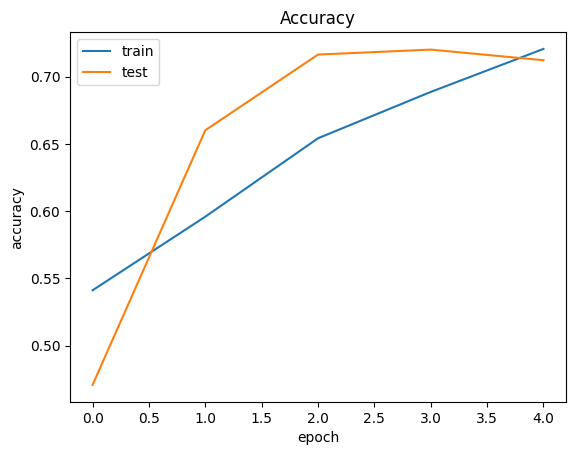

In [19]:
import matplotlib.pyplot as plt
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title("Accuracy")
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train','test'])
plt.show()

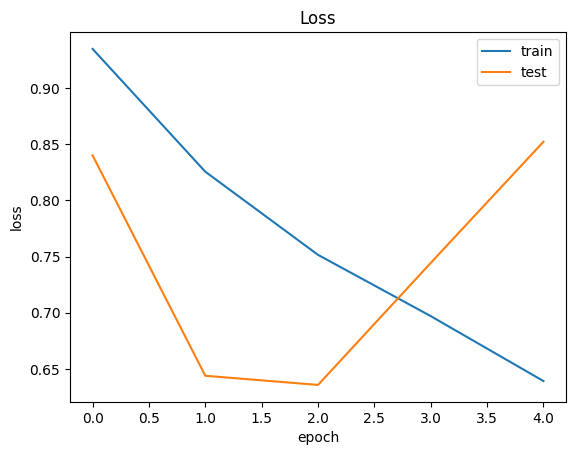

In [20]:
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("Loss")
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train','test'])
plt.show()

In [21]:
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
   
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

60/60 [==============================] - 77s 1s/step


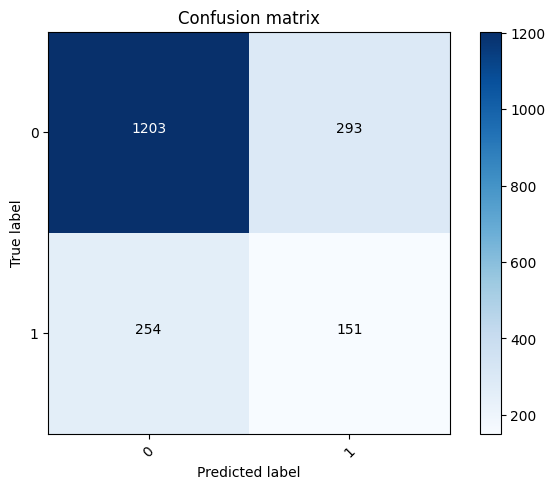

In [22]:
Y_pred = model1.predict(x_dev)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(y_dev,axis = 1) 
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 
plot_confusion_matrix(confusion_mtx, classes = range(2))

In [23]:
from sklearn.metrics import classification_report
print(classification_report(Y_true, Y_pred_classes))

              precision    recall  f1-score   support

           0       0.83      0.80      0.81      1496
           1       0.34      0.37      0.36       405

    accuracy                           0.71      1901
   macro avg       0.58      0.59      0.59      1901
weighted avg       0.72      0.71      0.72      1901

